COMP721 - Mini Project

216063593 - Benjamin Naidoo

218015230 - Kailin Reddy

# All Imports

In [11]:
# All Imports

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, explained_variance_score, max_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
# from scipy.stats import iqr

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Outlier Detection - KNN

In [2]:
# Defined Methods

def perform_PCA(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
    return principalDf

def outlierDetect(df1, year, start, end, name):
    df = df1.iloc[:, start:end].fillna(0)

    principalDf = perform_PCA(df)
    X = principalDf.values

    nbrs = NearestNeighbors(n_neighbors=3)
    nbrs.fit(X)
    # distances and indexes of k-neighbors from model outputs
    distances, indexes = nbrs.kneighbors(X)  
    # plot mean of k-distances of each observation

    player_playoffs_outlier_index = np.where(distances.mean(axis=1) > 1)

    startIndex = df.index[0]
    updatedOutlierIndices = []
    for i in range(len(player_playoffs_outlier_index[0])):
        updatedOutlierIndices.append(player_playoffs_outlier_index[0][i] + startIndex)

    outlier_values = principalDf.iloc[player_playoffs_outlier_index]
    Y = df1.iloc[player_playoffs_outlier_index]

    data_with_clusters = Y.copy()
    data_with_clusters['PrincipalComponent1'] = 0.0
    data_with_clusters['PrincipalComponent2'] = 0.0

    for i in range(len(updatedOutlierIndices)):
        data_with_clusters['PrincipalComponent1'][updatedOutlierIndices[i]] = principalDf['principal component 1'][player_playoffs_outlier_index[0][i]]
        data_with_clusters['PrincipalComponent2'][updatedOutlierIndices[i]] = principalDf['principal component 2'][player_playoffs_outlier_index[0][i]]

    indexArray = []
    count = 0

    for index in updatedOutlierIndices:
        for out in outlier_values["principal component 1"]:
            if (data_with_clusters['PrincipalComponent1'][index] == out):
                indexArray.append(index)
        count = count + 1

    indexArray2 = []
    count = 0

    for index in updatedOutlierIndices:
        for out in outlier_values["principal component 2"]:
            if (data_with_clusters['PrincipalComponent2'][index] == out):
                indexArray2.append(index)
        count = count + 1

    finalIndexArray = []

    for m in indexArray:
        for n in indexArray2:
            if (m == n):
                finalIndexArray.append(m)

    if (year < 0):
        print('The Outstanding players for ' + name + ' are : ')
    else:
        print('The Outstanding players for ' + name + ' in the year ' + str(year) + ' are : ')
    print('================================================================================')
    for i in finalIndexArray:
        print(data_with_clusters['firstname'][i] + ' ' + data_with_clusters['lastname'][i])

    print("===============================================================================")

    # plot outlier values
    plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], color="gray",)
    plt.scatter(outlier_values["principal component 1"], outlier_values["principal component 2"], color="red")
    plt.show()

def readPlayerFiles(filename, start, end, name):
    df = pd.read_csv(filename, header=0).fillna(0)


    if "year" in df.columns:
        df1 = df.sort_values(by='year')
        df1 = df1.reset_index(drop=True)

        dataFrameArr = []
        years = []
        for year in df1["year"]:
            if (year not in years):
                years.append(year)

        for year in years:
            newDataFrame = df1.query("year==" + str(year))
            dataFrameArr.append(newDataFrame)

        for i in range(len(dataFrameArr)):
            newOutlier = dataFrameArr[i]
            outlierDetect(newOutlier, years[i], start, end, name)
            print()
            print()

    else:
        outlierDetect(df, -1, start, end, name)
        print()
        print()

# Outlier Detection - KMeans

In [4]:
# Defined Methods

def perform_PCA(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
    return principalDf


def get_Dist(x1, y1, x2, y2):
    diffX = x2 - x1
    diffY = y2 - y1
    if diffX <= 0 and diffY <= 0:
        return 0
    else:
        return math.sqrt(math.pow(x2 - x1, 2) + math.pow(y2 - y1, 2))


def outlierDetect(df, year, start, end, name):
    df1 = df.iloc[:, start:end]

    principalDF = perform_PCA(df1)

    model = KMeans(n_clusters=1, random_state=0)
    identified_clusters = model.fit(principalDF[['principal component 1', 'principal component 2']])
    clusterCenter = model.cluster_centers_[0]
    x1 = clusterCenter[0]
    y1 = clusterCenter[1]

    identified_clusters1 = identified_clusters.predict(principalDF[['principal component 1', 'principal component 2']])

    data_with_clusters = df.copy()

    data_with_clusters['Clusters'] = identified_clusters1
    data_with_clusters['PC1'] = 0.0
    data_with_clusters['PC2'] = 0.0
    startIndex = data_with_clusters.index[0]

    for i in range(len(data_with_clusters['firstname'])):
        data_with_clusters['PC1'][i + startIndex] = principalDF['principal component 1'][i]
        data_with_clusters['PC2'][i + startIndex] = principalDF['principal component 2'][i]

    data_with_clusters['distFromCentre'] = 0.0

    for i in range(len(data_with_clusters['PC1'])):
        data_with_clusters['distFromCentre'][i + startIndex] = get_Dist(x1, y1, data_with_clusters["PC1"][i + startIndex], data_with_clusters['PC2'][i + startIndex])

    thresh1 = (max(data_with_clusters["PC1"]) + max(data_with_clusters["PC2"])) / 2
    df = data_with_clusters.query("distFromCentre > " + str(thresh1))

    if (year < 0):
        print('The Outstanding players for ' + name + ' are : ')
    else:
        print('The Outstanding players for ' + name + ' in the year ' + str(year) + ' are : ')

    print('================================================================================')

    for i in df.index:
        print(df['firstname'][i] + ' ' + df['lastname'][i])

    print("================================================================================")

    plt.scatter(principalDF['principal component 1'], principalDF['principal component 2'], color='gray')
    plt.scatter(df['PC1'], df['PC2'], color='red')
    plt.show()

def readPlayerFiles(filename, start, end, name):
    df = pd.read_csv(filename, header=0).fillna(0)

    if "year" in df.columns:
        df1 = df.sort_values(by='year')
        df1 = df1.reset_index(drop=True)

        dataFrameArr = []
        years = []
        for year in df1["year"]:
            if (year not in years):
                years.append(year)

        for year in years:
            newDataFrame = df1.query("year==" + str(year))
            dataFrameArr.append(newDataFrame)

        for i in range(len(dataFrameArr)):
            newOutlier = dataFrameArr[i]
            outlierDetect(newOutlier, years[i], start, end, name)
            print()
            print()


    else:
        outlierDetect(df, -1, start, end, name)
        print()
        print()

# Running Outlier Detection

The Outstanding players for NBA Regular Seasons in general are : 
Kareem Abdul-jabbar
Karl Malone
Moses Malone
Reggie Miller
Hakeem Olajuwon
John Stockton


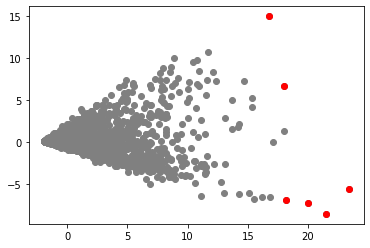



The Outstanding players for NBA Playoffs in General are : 
Kareem Abdul-jabbar
Larry Bird
Magic Johnson
Michael Jordan
Karl Malone
Hakeem Olajuwon
Shaquille O'neal
Scottie Pippen


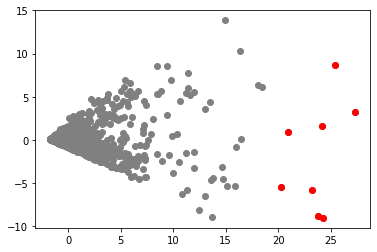



The Outstanding players for NBA Regular Seasons in the year 1946 are : 
Ernie Calverley
Joe Fulks


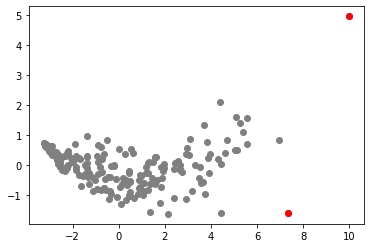



The Outstanding players for NBA Regular Seasons in the year 1947 are : 
Stan Miasek
Max Zaslofsky
Ed Sadowski
Joe Fulks


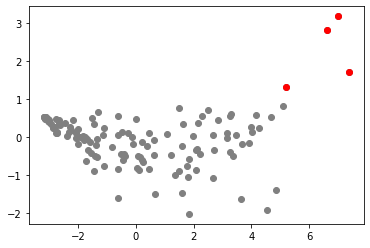



The Outstanding players for NBA Regular Seasons in the year 1948 are : 
George Mikan
Joe Fulks


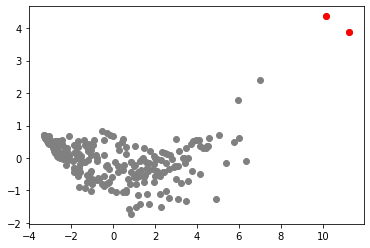



The Outstanding players for NBA Regular Seasons in the year 1949 are : 
George Mikan
Alex Groza


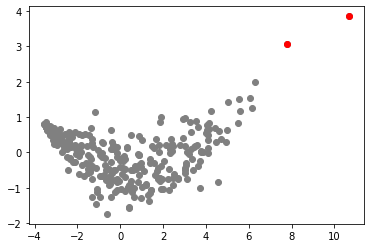



The Outstanding players for NBA Regular Seasons in the year 1950 are : 
George Mikan
Ed Macauley
Dolph Schayes
Alex Groza


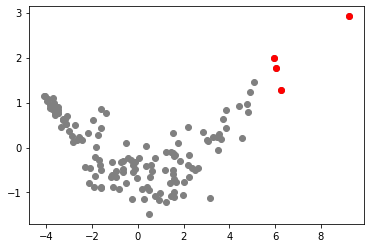



The Outstanding players for NBA Regular Seasons in the year 1951 are : 
George Mikan
Ed Macauley
Bob Cousy
Paul Arizin


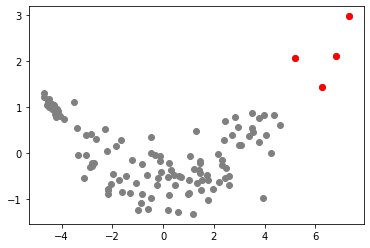



The Outstanding players for NBA Regular Seasons in the year 1952 are : 
George Mikan
Ed Macauley
Dolph Schayes
Bob Cousy
Neil Johnston


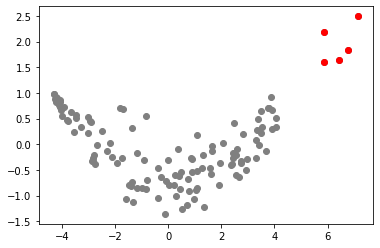



The Outstanding players for NBA Regular Seasons in the year 1953 are : 
George Mikan
Dolph Schayes
Bob Cousy
Ray Felix
Ed Macauley
Neil Johnston


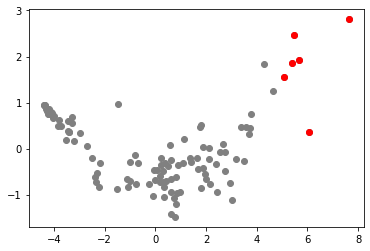



The Outstanding players for NBA Regular Seasons in the year 1954 are : 
Bob Pettit
Vern Mikkelsen
Frank Selvy
Dolph Schayes
Bob Cousy
Paul Arizin
Neil Johnston


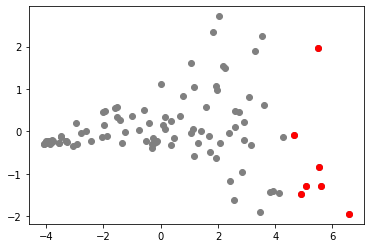



The Outstanding players for NBA Regular Seasons in the year 1955 are : 
Bob Pettit
Bob Santini
Dolph Schayes
Clyde Lovellette
Ernie Vandeweghe
James Davis
Bob Cousy
Don Bielke
Paul Arizin
Ron Feiereisel
Neil Johnston
Johnny Horan


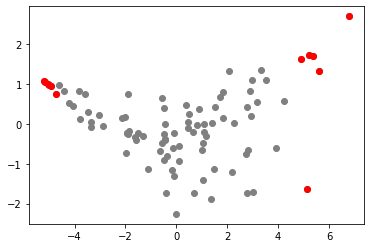



The Outstanding players for NBA Regular Seasons in the year 1956 are : 
Bob Pettit
Maurice Stokes
Dolph Schayes
Clyde Lovellette
George Yardley
Bob Cousy
Paul Arizin
Neil Johnston


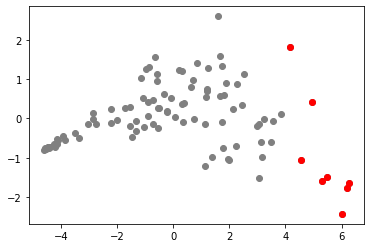



The Outstanding players for NBA Regular Seasons in the year 1957 are : 
Bob Pettit
George Yardley
Dolph Schayes


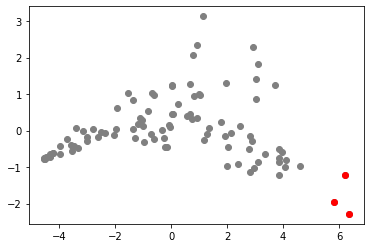



The Outstanding players for NBA Regular Seasons in the year 1958 are : 
Brendan Mccann
Bob Pettit
Jack Twyman
Dolph Schayes
Jerry Bird
Elgin Baylor
Paul Arizin
Tommy Kearns
Dave Gambee
Cliff Hagan


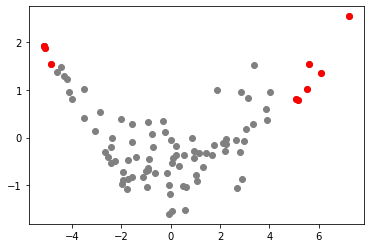



The Outstanding players for NBA Regular Seasons in the year 1959 are : 
Jack Twyman
Wilt Chamberlain
Elgin Baylor


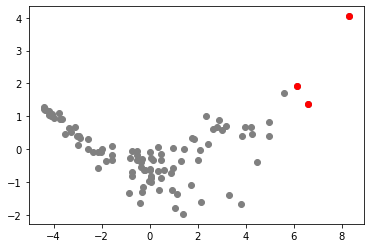



The Outstanding players for NBA Regular Seasons in the year 1960 are : 
Wilt Chamberlain
Elgin Baylor


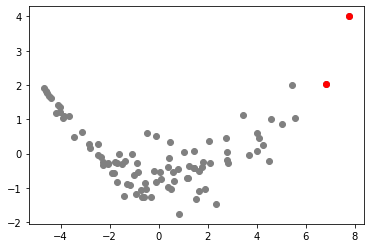



The Outstanding players for NBA Regular Seasons in the year 1961 are : 
Wilt Chamberlain


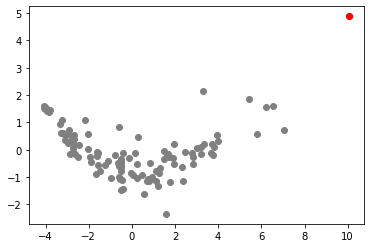



The Outstanding players for NBA Regular Seasons in the year 1962 are : 
Wilt Chamberlain
Elgin Baylor


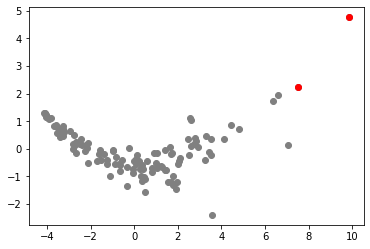



The Outstanding players for NBA Regular Seasons in the year 1963 are : 
Bob Pettit
Oscar Robertson
Wilt Chamberlain
Walt Bellamy


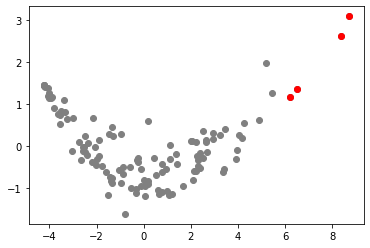



The Outstanding players for NBA Regular Seasons in the year 1964 are : 
Jerry West
Oscar Robertson
Wilt Chamberlain
Walt Bellamy
Elgin Baylor


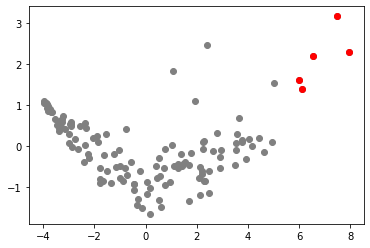



The Outstanding players for NBA Regular Seasons in the year 1965 are : 
Oscar Robertson
Jerry West
Wilt Chamberlain


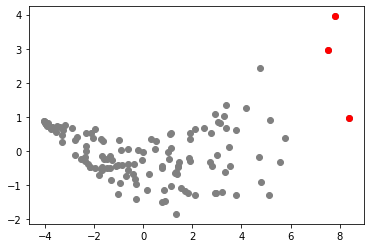



The Outstanding players for NBA Regular Seasons in the year 1966 are : 
Oscar Robertson
Wilt Chamberlain
Rick Barry


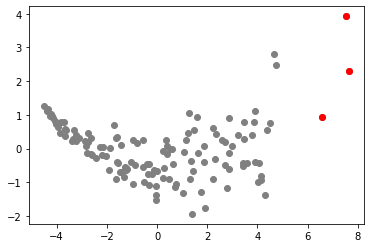



The Outstanding players for NBA Regular Seasons in the year 1967 are : 
Chico Vaughn
Les Selvage


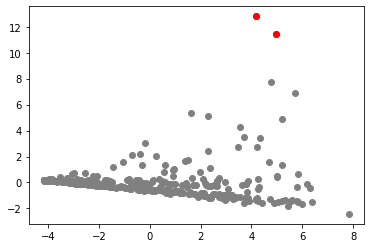



The Outstanding players for NBA Regular Seasons in the year 1968 are : 
Chico Vaughn
Lou Dampier


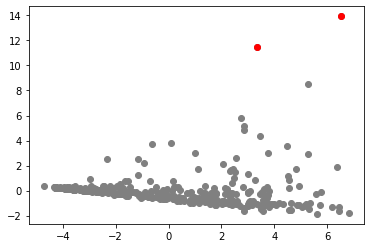



The Outstanding players for NBA Regular Seasons in the year 1969 are : 
Glen Combs
Lou Dampier


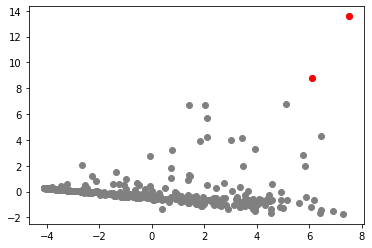



The Outstanding players for NBA Regular Seasons in the year 1970 are : 
Al Tucker


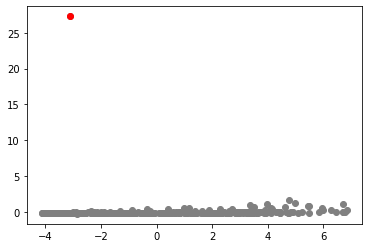



The Outstanding players for NBA Regular Seasons in the year 1971 are : 
Lou Dampier
Glen Combs
Rick Barry
Warren Jabali


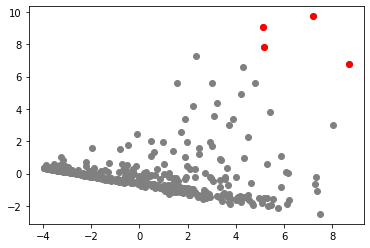



The Outstanding players for NBA Regular Seasons in the year 1972 are : 
Billy Keller
Joe Hamilton


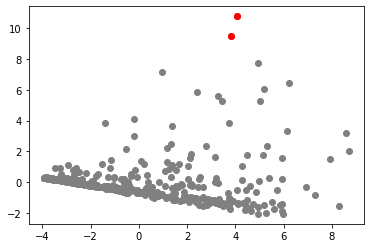



The Outstanding players for NBA Regular Seasons in the year 1973 are : 
Bo Lamar
Julius Erving


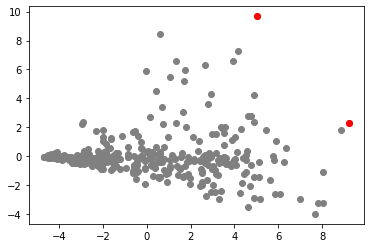



The Outstanding players for NBA Regular Seasons in the year 1974 are : 
George Mcginnis


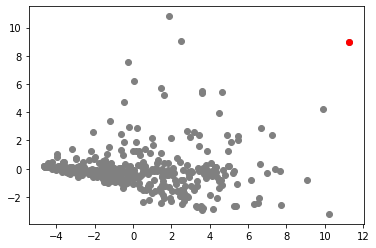



The Outstanding players for NBA Regular Seasons in the year 1975 are : 
Billy Keller


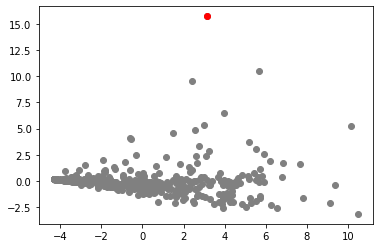



The Outstanding players for NBA Regular Seasons in the year 1976 are : 
Moses Malone
Moses Malone
Pete Maravich
George Mcginnis
Bob Mcadoo
Kareem Abdul-jabbar
Elvin Hayes
Julius Erving
Artis Gilmore


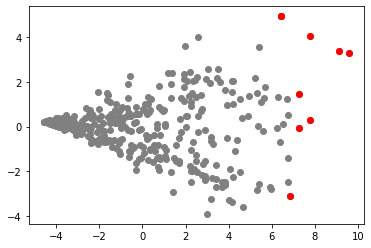



The Outstanding players for NBA Regular Seasons in the year 1977 are : 
Truck Robinson
George Mcginnis
Bob Mcadoo
Marvin Webster
David Thompson
Randy Smith
Bernard King
Elvin Hayes
Dan Issel
Artis Gilmore
George Gervin


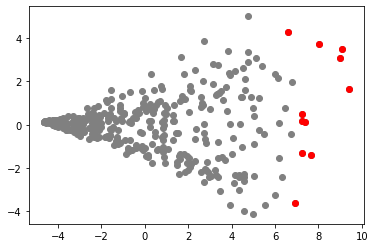



The Outstanding players for NBA Regular Seasons in the year 1978 are : 
George Mcginnis
Moses Malone
Rich Kelley
Kareem Abdul-jabbar
Elvin Hayes
World Free
Artis Gilmore


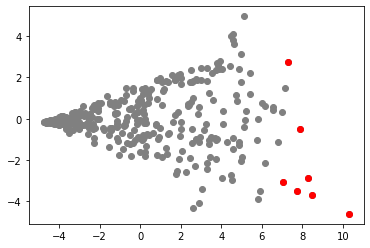



The Outstanding players for NBA Regular Seasons in the year 1979 are : 
Moses Malone
Brian Taylor


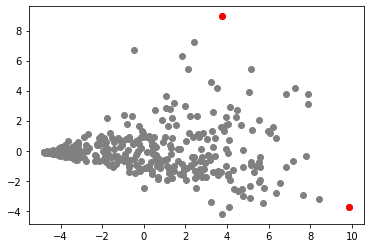



The Outstanding players for NBA Regular Seasons in the year 1980 are : 
Moses Malone


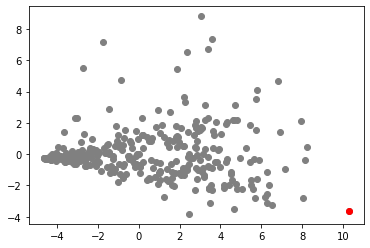



The Outstanding players for NBA Regular Seasons in the year 1981 are : 
Moses Malone


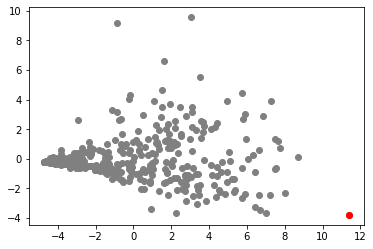



The Outstanding players for NBA Regular Seasons in the year 1982 are : 
Allen Leavell
Moses Malone
Isiah Thomas
Mike Dunleavy


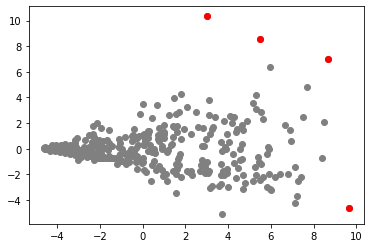



The Outstanding players for NBA Regular Seasons in the year 1983 are : 
Darrell Griffith


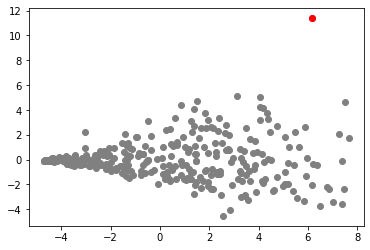



The Outstanding players for NBA Regular Seasons in the year 1984 are : 
Moses Malone
Hakeem Olajuwon
Purvis Short
Isiah Thomas
Larry Bird
Michael Jordan
Darrell Griffith


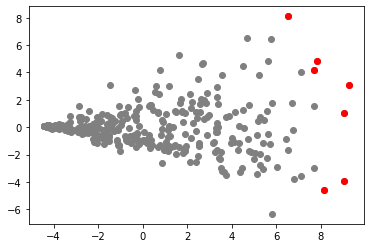



The Outstanding players for NBA Regular Seasons in the year 1985 are : 
Moses Malone
Dominique Wilkins
Larry Bird
Charles Barkley
World Free


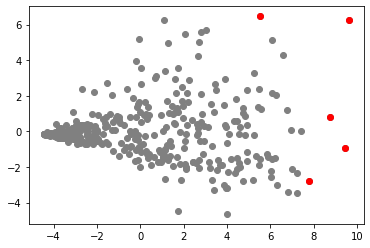



The Outstanding players for NBA Regular Seasons in the year 1986 are : 
Hakeem Olajuwon
Larry Bird
Michael Jordan
Dale Ellis
Sleepy Floyd


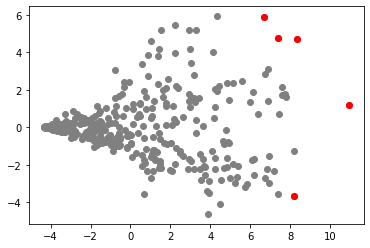



The Outstanding players for NBA Regular Seasons in the year 1987 are : 
Karl Malone
Charles Barkley
Michael Adams
Michael Jordan


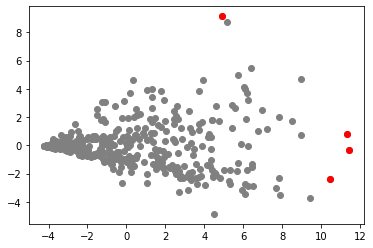



The Outstanding players for NBA Regular Seasons in the year 1988 are : 
Hakeem Olajuwon
Karl Malone
Dale Ellis
Charles Barkley
Michael Adams
Michael Jordan


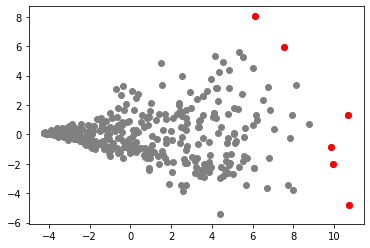



The Outstanding players for NBA Regular Seasons in the year 1989 are : 
Hakeem Olajuwon
Mark Price
David Robinson
Karl Malone
Reggie Miller
Patrick Ewing
Magic Johnson
Michael Jordan


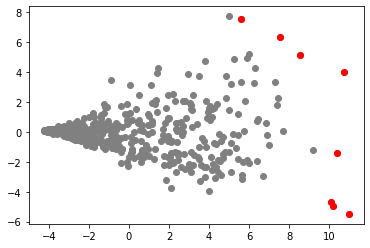



The Outstanding players for NBA Regular Seasons in the year 1990 are : 
Karl Malone
David Robinson
Michael Adams
Patrick Ewing


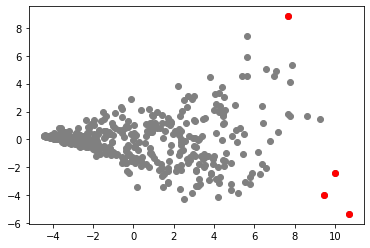



The Outstanding players for NBA Regular Seasons in the year 1991 are : 
Hakeem Olajuwon
Glen Rice
Karl Malone
Reggie Miller
Vernon Maxwell
Kevin Willis
David Robinson
John Stockton
Michael Adams
Charles Barkley
Tim Hardaway
Michael Jordan
Patrick Ewing
Clyde Drexler


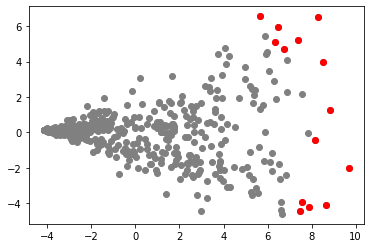



The Outstanding players for NBA Regular Seasons in the year 1992 are : 
Shaquille O'neal
Hakeem Olajuwon
Karl Malone
Dikembe Mutombo
Alonzo Mourning
Reggie Miller
David Robinson
Charles Barkley
Michael Jordan
Patrick Ewing


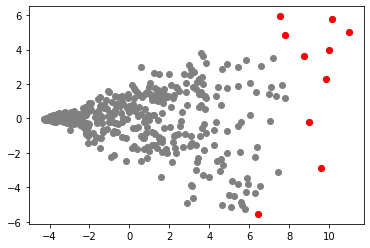



The Outstanding players for NBA Regular Seasons in the year 1993 are : 
Dikembe Mutombo
Hakeem Olajuwon
Shaquille O'neal
Karl Malone
David Robinson
Latrell Sprewell
Patrick Ewing


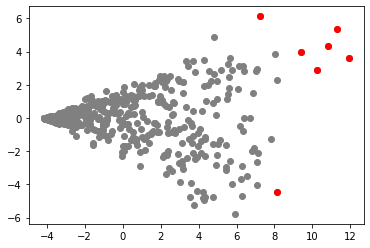



The Outstanding players for NBA Regular Seasons in the year 1994 are : 
Shaquille O'neal
Dikembe Mutombo
Hakeem Olajuwon
Scottie Pippen
Karl Malone
Alonzo Mourning
David Robinson
Shawn Kemp
Patrick Ewing


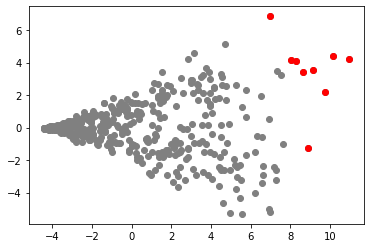



The Outstanding players for NBA Regular Seasons in the year 1995 are : 
David Robinson
Mitch Richmond
Hakeem Olajuwon
Karl Malone
Dikembe Mutombo
Alonzo Mourning
Michael Jordan
Grant Hill
Shawn Kemp
Jason Kidd
Patrick Ewing


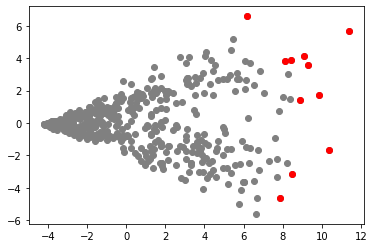



The Outstanding players for NBA Regular Seasons in the year 1996 are : 
Hakeem Olajuwon
Gary Payton
Glen Rice
Mitch Richmond
Dikembe Mutombo
Scottie Pippen
Karl Malone
Reggie Miller
Latrell Sprewell
Jerry Stackhouse
Damon Stoudamire
Vin Baker
Kenny Anderson
Mookie Blaylock
Allen Iverson
Grant Hill
Michael Jordan
Shawn Kemp
Patrick Ewing
Tim Hardaway
Kendall Gill
Tom Gugliotta


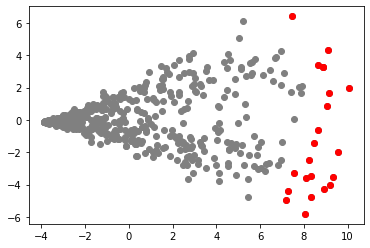



The Outstanding players for NBA Regular Seasons in the year 1997 are : 
Gary Payton
David Robinson
Dikembe Mutombo
Antoine Walker
Karl Malone
Ray Allen
Shareef Abdur-rahim
Tim Duncan
Allen Iverson
Grant Hill
Michael Jordan
Shawn Kemp
Kevin Garnett
Tim Hardaway


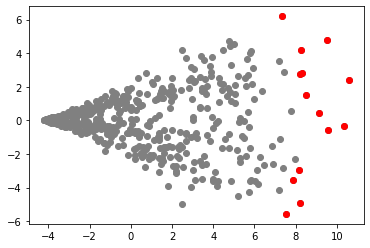



The Outstanding players for NBA Regular Seasons in the year 1998 are : 
Shaquille O'neal
Hakeem Olajuwon
Dikembe Mutombo
Gary Payton
Stephon Marbury
Karl Malone
Alonzo Mourning
Antonio Mcdyess
Chris Webber
Jason Williams
David Robinson
Shareef Abdur-rahim
Allen Iverson
Grant Hill
Jason Kidd
Tim Duncan
Tim Hardaway
Kevin Garnett


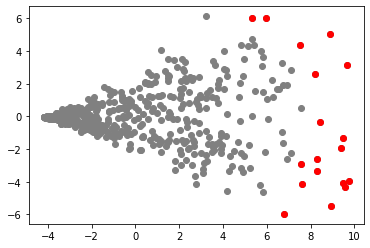



The Outstanding players for NBA Regular Seasons in the year 1999 are : 
Dikembe Mutombo
Alonzo Mourning
Shaquille O'neal
Gary Payton
Karl Malone
Tim Duncan
Kevin Garnett


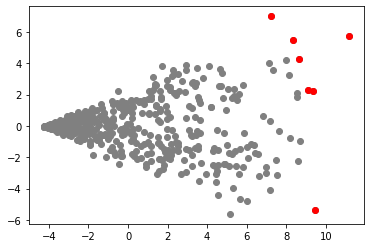



The Outstanding players for NBA Regular Seasons in the year 2000 are : 
Dirk Nowitzki
Paul Pierce
Shaquille O'neal
Karl Malone
Tracy Mcgrady
Antoine Walker
Chris Webber
Jerry Stackhouse
Vince Carter
Ray Allen
Allen Iverson
Antawn Jamison
Steve Francis
Tim Duncan
Kevin Garnett


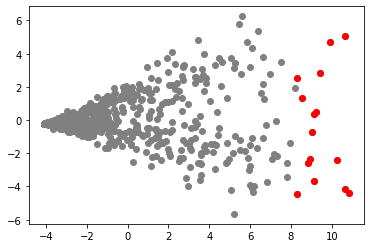



The Outstanding players for NBA Regular Seasons in the year 2001 are : 
Paul Pierce
Shaquille O'neal
Karl Malone
Tracy Mcgrady
Antoine Walker
Jason Kidd
Kobe Bryant
Baron Davis
Elton Brand
Tim Duncan
Kevin Garnett


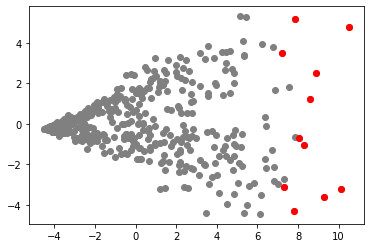



The Outstanding players for NBA Regular Seasons in the year 2002 are : 
Dirk Nowitzki
Paul Pierce
Tracy McGrady
Kobe Bryant
Allen Iverson
Kevin Garnett
Tim Duncan


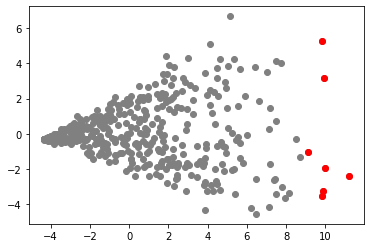



The Outstanding players for NBA Regular Seasons in the year 2003 are : 
Jermaine O'Neal
Shaquille O'Neal
Paul Pierce
Stephon Marbury
Tracy McGrady
Ben Wallace
Predrag Stojakovic
Baron Davis
Andrei Kirilenko
Tim Duncan
Kevin Garnett


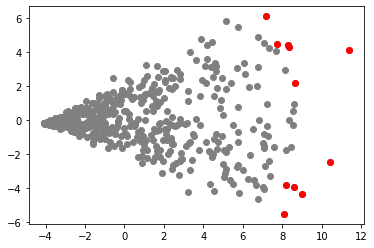



The Outstanding players for NBA Regular Seasons in the year 2004 are : 
Shaquille O'Neal
Dirk Nowitzki
Paul Pierce
Stephon Marbury
Shawn Marion
Yao Ming
Tracy McGrady
Dwyane Wade
Amare Stoudemire
Vince Carter
Elton Brand
Kobe Bryant
Gilbert Arenas
Ray Allen
Mike Bibby
Zydrunas Ilgauskas
Allen Iverson
LeBron James
Steve Francis
Kevin Garnett


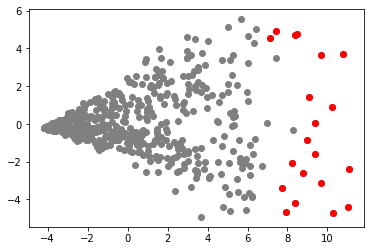



The Outstanding players for NBA Playoffs in the year 1949 are : 
George Mikan


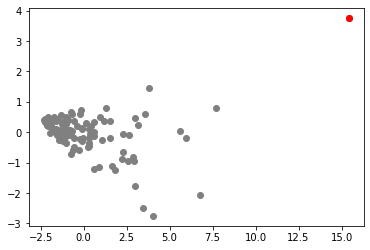



The Outstanding players for NBA Playoffs in the year 1950 are : 
Max Zaslofsky
Arnie Risen
Bob Davies


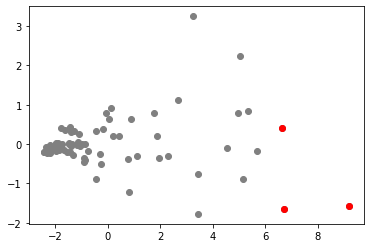



The Outstanding players for NBA Playoffs in the year 1951 are : 
George Mikan


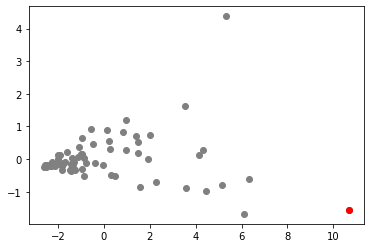



The Outstanding players for NBA Playoffs in the year 1952 are : 
George Mikan


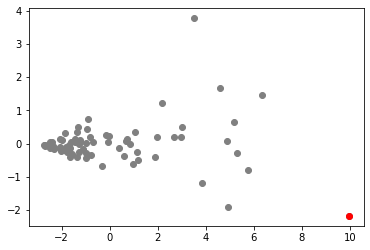



The Outstanding players for NBA Playoffs in the year 1953 are : 
George Mikan
Dolph Schayes
Paul Seymour


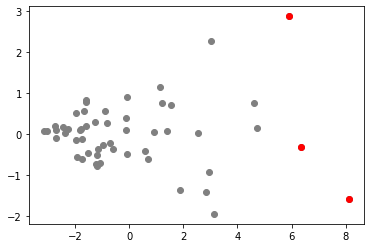



The Outstanding players for NBA Playoffs in the year 1954 are : 
Dolph Schayes
George Yardley
Larry Foust


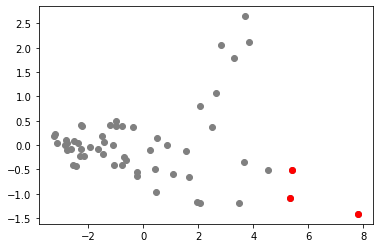



The Outstanding players for NBA Playoffs in the year 1955 are : 
George Yardley
Dolph Schayes
Paul Arizin
Larry Foust
Neil Johnston


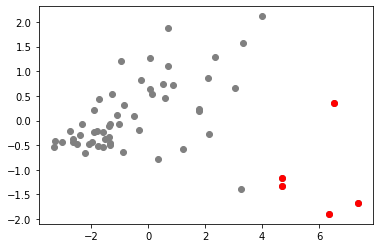



The Outstanding players for NBA Playoffs in the year 1956 are : 
Bob Pettit
Bob Cousy


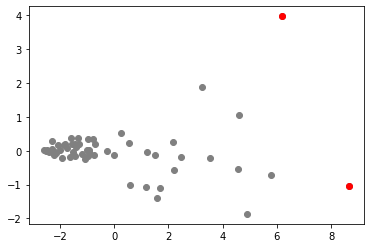



The Outstanding players for NBA Playoffs in the year 1957 are : 
Bob Pettit
Bob Cousy
Cliff Hagan


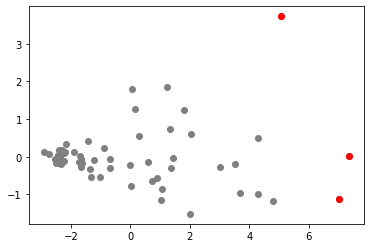



The Outstanding players for NBA Playoffs in the year 1958 are : 
Elgin Baylor
Bob Cousy


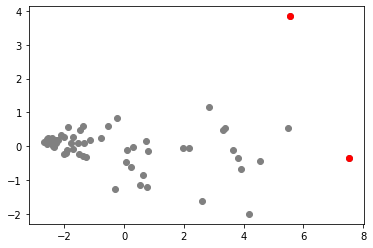



The Outstanding players for NBA Playoffs in the year 1959 are : 
Bob Pettit
Wilt Chamberlain
Cliff Hagan


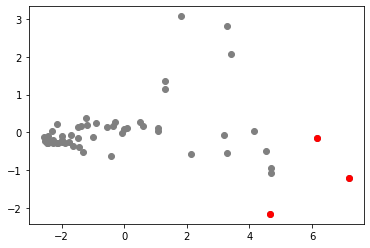



The Outstanding players for NBA Playoffs in the year 1960 are : 
Bob Pettit
Elgin Baylor


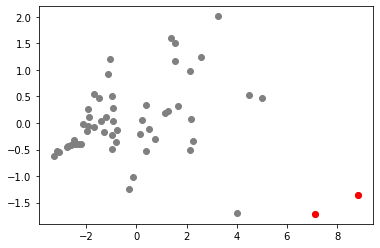



The Outstanding players for NBA Playoffs in the year 1961 are : 
Bill Russell
Jerry West
Elgin Baylor
Wilt Chamberlain


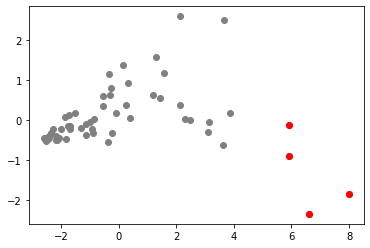



The Outstanding players for NBA Playoffs in the year 1962 are : 
Bob Pettit
Oscar Robertson
Bill Russell
Elgin Baylor


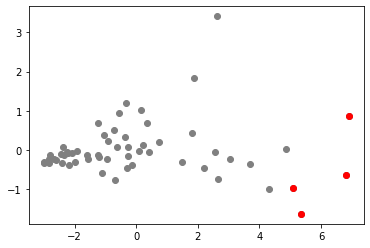



The Outstanding players for NBA Playoffs in the year 1963 are : 
Oscar Robertson
Wilt Chamberlain


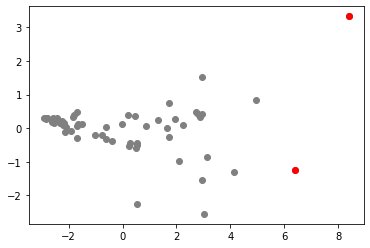



The Outstanding players for NBA Playoffs in the year 1964 are : 
Bill Russell
Jerry West
Wilt Chamberlain


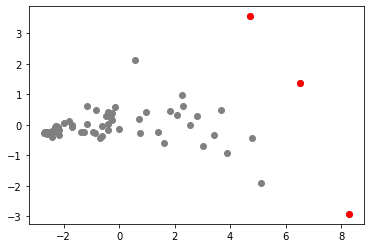



The Outstanding players for NBA Playoffs in the year 1965 are : 
Bill Russell
Jerry West
Sam Jones
Elgin Baylor
John Havlicek


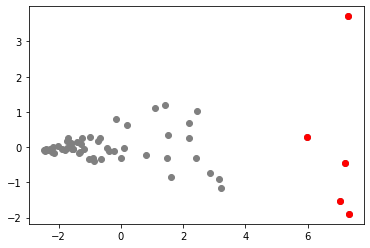



The Outstanding players for NBA Playoffs in the year 1966 are : 
Wilt Chamberlain
Rick Barry
Hal Greer


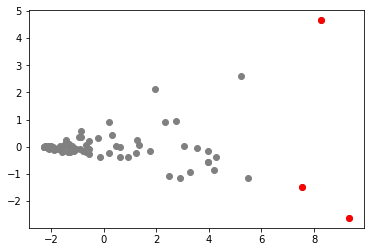



The Outstanding players for NBA Playoffs in the year 1967 are : 
Jerry West
Bill Russell
John Havlicek
Connie Hawkins


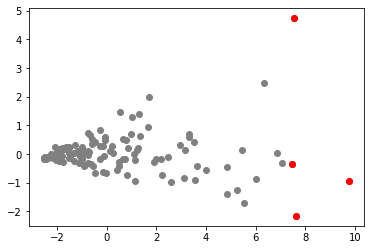



The Outstanding players for NBA Playoffs in the year 1968 are : 
Jerry West
Rogera Brown
John Havlicek


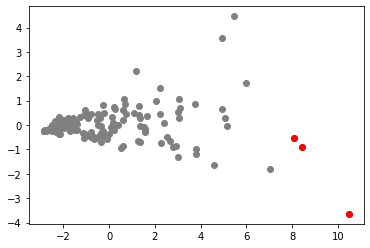



The Outstanding players for NBA Playoffs in the year 1969 are : 
Warren Jabali


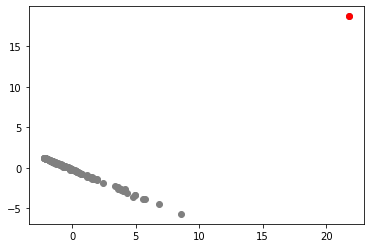



The Outstanding players for NBA Playoffs in the year 1970 are : 
Warren Jabali


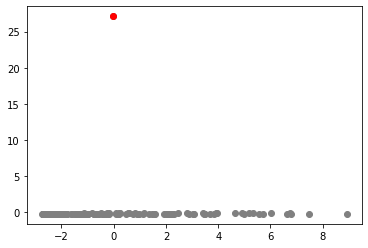



The Outstanding players for NBA Playoffs in the year 1971 are : 
Billy Paultz
Freddie Lewis
George Mcginnis
Jerry West
John Roche
Mel Daniels
Rick Barry
Rogera Brown
Walt Frazier


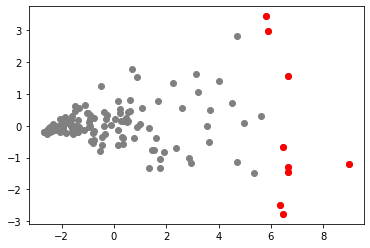



The Outstanding players for NBA Playoffs in the year 1972 are : 
George Mcginnis
Jerry West
Dan Issel
Walt Frazier
Artis Gilmore


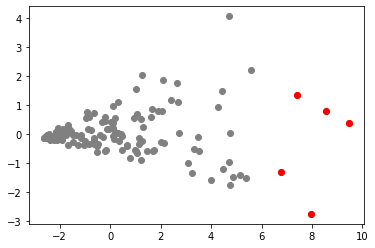



The Outstanding players for NBA Playoffs in the year 1973 are : 
Dave Cowens


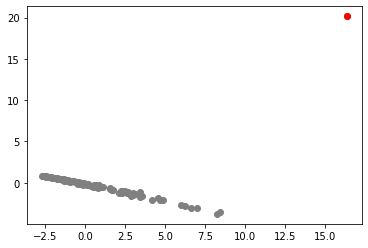



The Outstanding players for NBA Playoffs in the year 1974 are : 
Nate Archibald


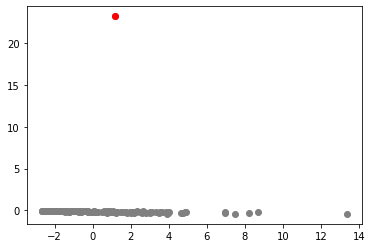



The Outstanding players for NBA Playoffs in the year 1975 are : 
World Free


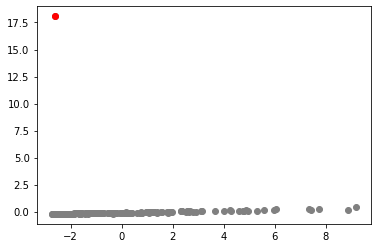



The Outstanding players for NBA Playoffs in the year 1976 are : 
World Free


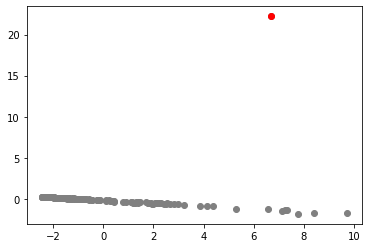



The Outstanding players for NBA Playoffs in the year 1977 are : 
World Free


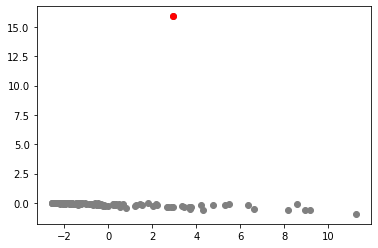



The Outstanding players for NBA Playoffs in the year 1978 are : 
Gus Williams
Bob Dandridge
Dennis Johnson
Elvin Hayes


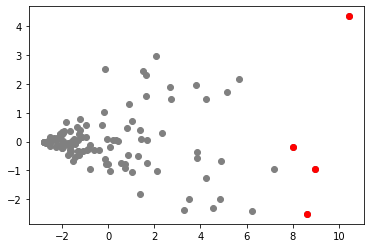



The Outstanding players for NBA Playoffs in the year 1979 are : 
Magic Johnson
Kareem Abdul-jabbar
Julius Erving


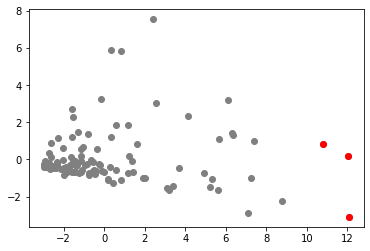



The Outstanding players for NBA Playoffs in the year 1980 are : 
Moses Malone


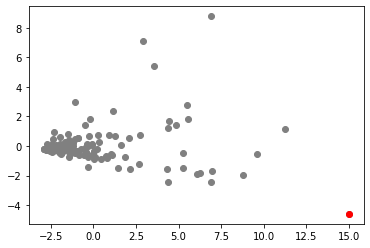



The Outstanding players for NBA Playoffs in the year 1981 are : 
Andrew Toney
Julius Erving


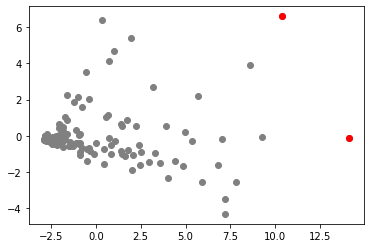



The Outstanding players for NBA Playoffs in the year 1982 are : 
Moses Malone
Johnny Moore
Kareem Abdul-jabbar
Magic Johnson


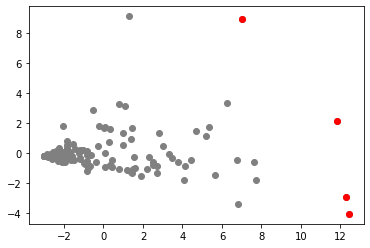



The Outstanding players for NBA Playoffs in the year 1983 are : 
Larry Bird


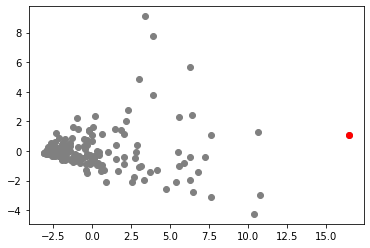



The Outstanding players for NBA Playoffs in the year 1984 are : 
Robert Parish
Kevin Mchale
Larry Bird


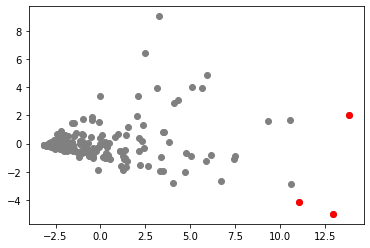



The Outstanding players for NBA Playoffs in the year 1985 are : 
Hakeem Olajuwon
Ralph Sampson
Larry Bird


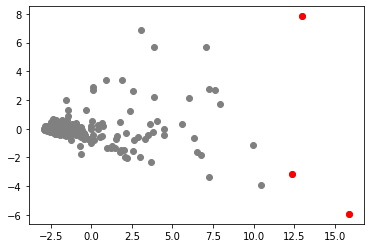



The Outstanding players for NBA Playoffs in the year 1986 are : 
Larry Bird


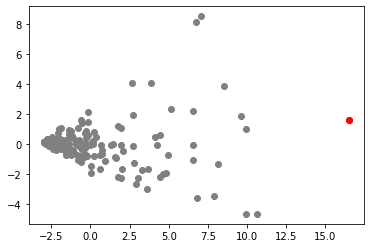



The Outstanding players for NBA Playoffs in the year 1987 are : 
James Worthy
Byron Scott
Roy Tarpley
Isiah Thomas
Larry Bird
Magic Johnson


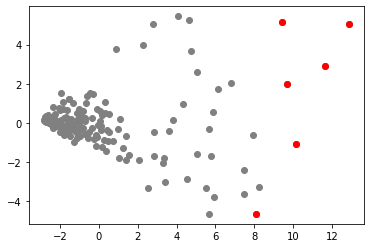



The Outstanding players for NBA Playoffs in the year 1988 are : 
Michael Jordan


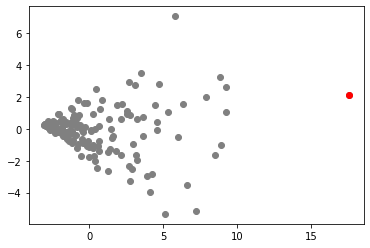



The Outstanding players for NBA Playoffs in the year 1989 are : 
Terry Porter
Isiah Thomas
Clyde Drexler
Michael Jordan
Jerome Kersey


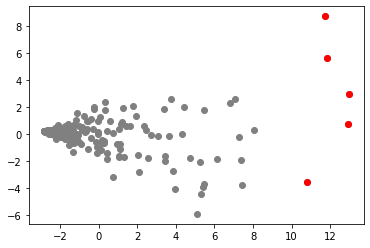



The Outstanding players for NBA Playoffs in the year 1990 are : 
Scottie Pippen
Sam Perkins
Clyde Drexler
Magic Johnson
Michael Jordan


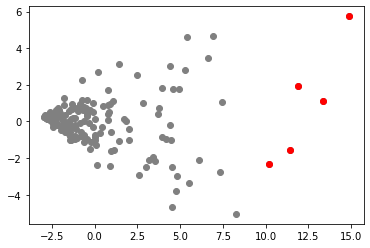



The Outstanding players for NBA Playoffs in the year 1991 are : 
Scottie Pippen
Terry Porter
Clyde Drexler
Michael Jordan


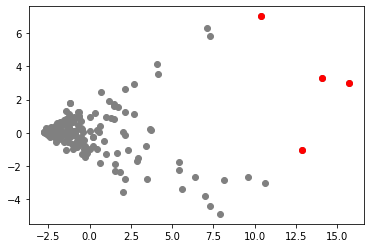



The Outstanding players for NBA Playoffs in the year 1992 are : 
Dan Majerle
Charles Barkley
Michael Jordan


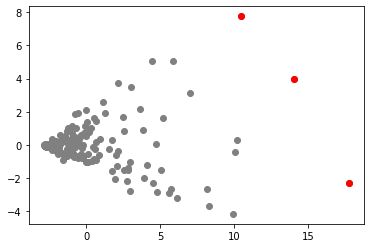



The Outstanding players for NBA Playoffs in the year 1993 are : 
Hakeem Olajuwon
John Starks
Patrick Ewing


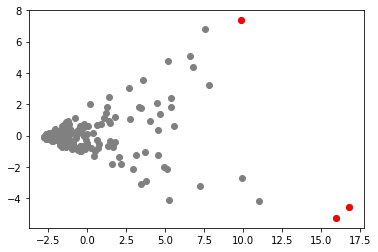



The Outstanding players for NBA Playoffs in the year 1994 are : 
Shaquille O'neal
Hakeem Olajuwon
David Robinson
Anfernee Hardaway
Clyde Drexler


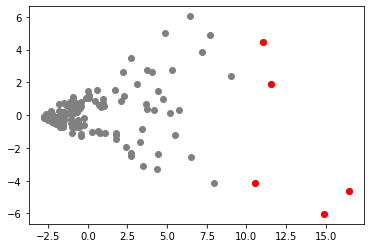



The Outstanding players for NBA Playoffs in the year 1995 are : 
Scottie Pippen
Gary Payton
Karl Malone
Michael Jordan
Shawn Kemp


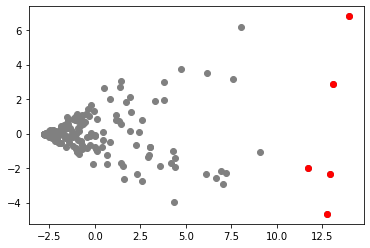



The Outstanding players for NBA Playoffs in the year 1996 are : 
Scottie Pippen
Hakeem Olajuwon
Alonzo Mourning
Karl Malone
Michael Jordan
Tim Hardaway


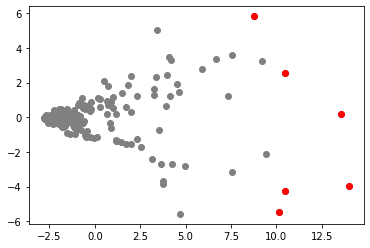



The Outstanding players for NBA Playoffs in the year 1997 are : 
Scottie Pippen
Karl Malone
Michael Jordan


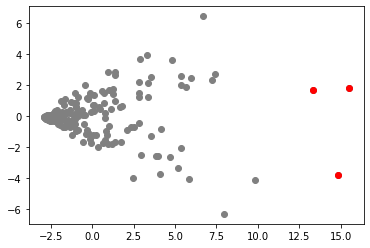



The Outstanding players for NBA Playoffs in the year 1998 are : 
Latrell Sprewell
David Robinson
Tim Duncan
Marcus Camby


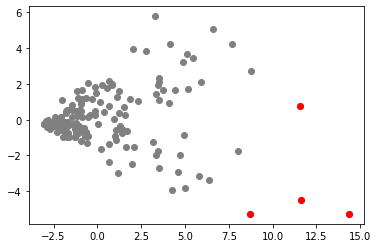



The Outstanding players for NBA Playoffs in the year 1999 are : 
Shaquille O'neal


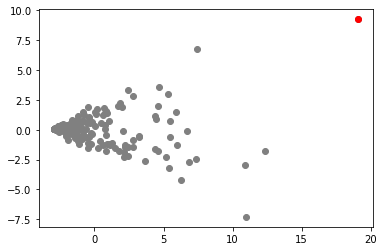



The Outstanding players for NBA Playoffs in the year 2000 are : 
Dikembe Mutombo
Shaquille O'neal
Allen Iverson


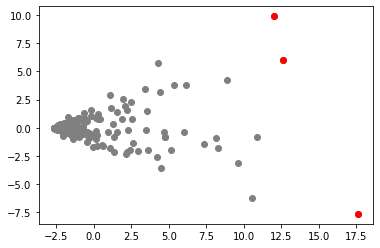



The Outstanding players for NBA Playoffs in the year 2001 are : 
Shaquille O'neal
Paul Pierce
Kobe Bryant
Jason Kidd


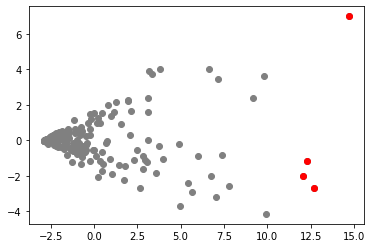



The Outstanding players for NBA Playoffs in the year 2002 are : 
Tim Duncan


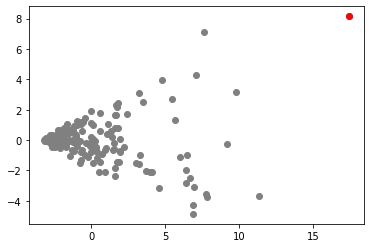



The Outstanding players for NBA Playoffs in the year 2003 are : 
Shaquille O'neal
Ben Wallace
Kobe Bryant
Chauncey Billups
Kevin Garnett
Richard Hamilton


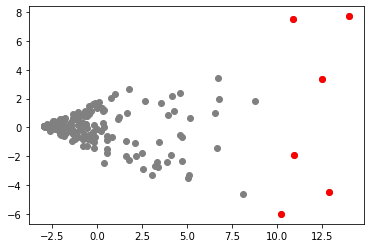



The Outstanding players for NBA Playoffs in the year 2004 are : 
Ben Wallace
Chauncey Billups
Tim Duncan
Emmanuel Ginobili


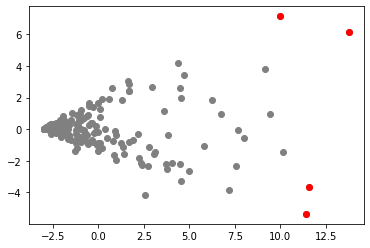



The Outstanding players for NBA All Star in the year 1950 are : 
Alex Groza
Ed Macauley
Joe Fulks


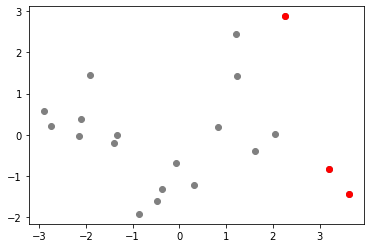



The Outstanding players for NBA All Star in the year 1951 are : 
George Mikan


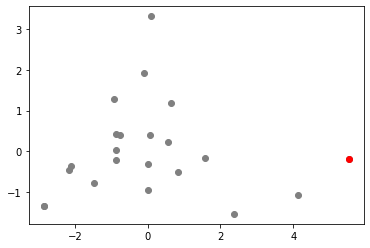



The Outstanding players for NBA All Star in the year 1952 are : 
Ed Macauley
George Mikan


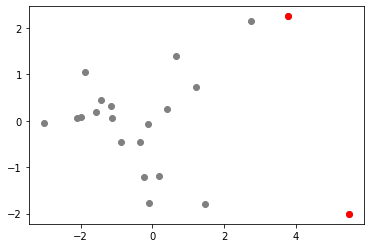



The Outstanding players for NBA All Star in the year 1953 are : 
Bob Cousy
Jim Pollard


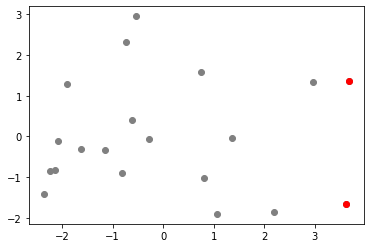



The Outstanding players for NBA All Star in the year 1954 are : 
Bob Cousy
Arnie Risen
Jim Pollard


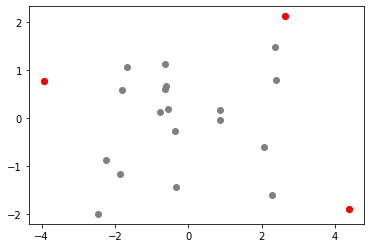



The Outstanding players for NBA All Star in the year 1955 are : 
Bob Pettit


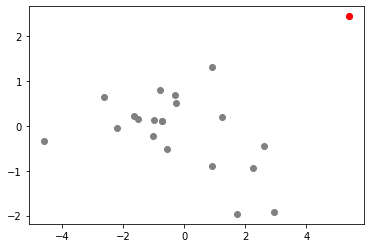



The Outstanding players for NBA All Star in the year 1956 are : 
Maurice Stokes
Bob Pettit


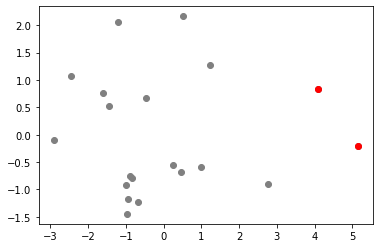



The Outstanding players for NBA All Star in the year 1957 are : 
Bob Pettit


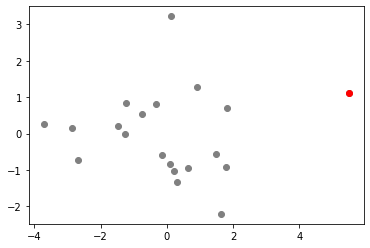



The Outstanding players for NBA All Star in the year 1958 are : 
Bob Pettit


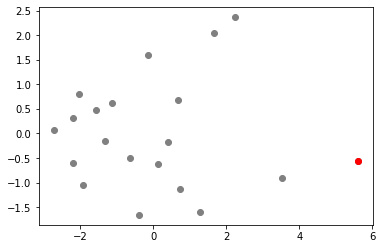



The Outstanding players for NBA All Star in the year 1959 are : 
Elgin Baylor
Bob Cousy
Wilt Chamberlain
Jack Twyman


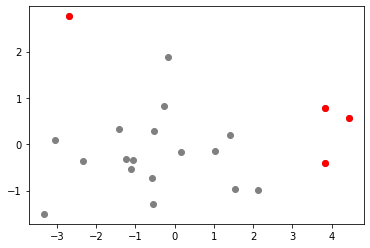



The Outstanding players for NBA All Star in the year 1960 are : 
Oscar Robertson
Wilt Chamberlain


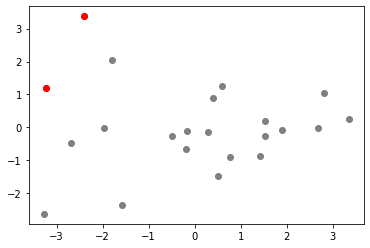



The Outstanding players for NBA All Star in the year 1961 are : 
Elgin Baylor
Oscar Robertson
Wilt Chamberlain


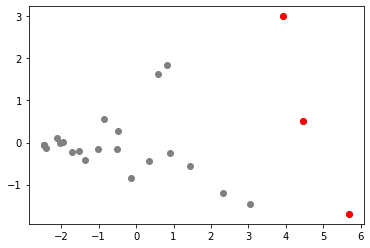



The Outstanding players for NBA All Star in the year 1962 are : 
Elgin Baylor
Bob Pettit
Bill Russell


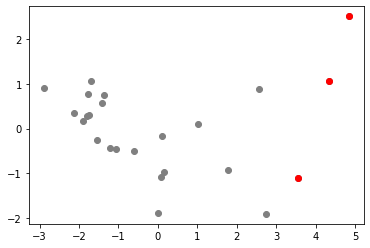



The Outstanding players for NBA All Star in the year 1963 are : 
Wilt Chamberlain
Oscar Robertson


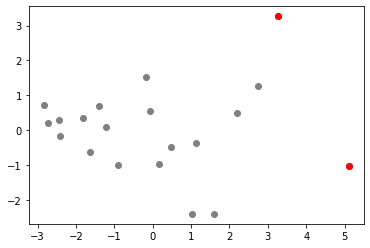



The Outstanding players for NBA All Star in the year 1964 are : 
Oscar Robertson


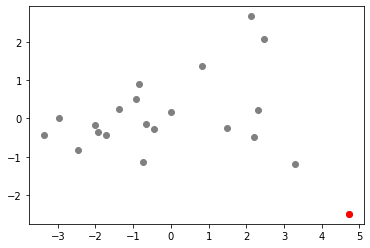



The Outstanding players for NBA All Star in the year 1965 are : 
Zelmo Beatty


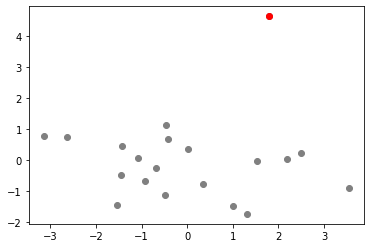



The Outstanding players for NBA All Star in the year 1966 are : 
Rick Barry


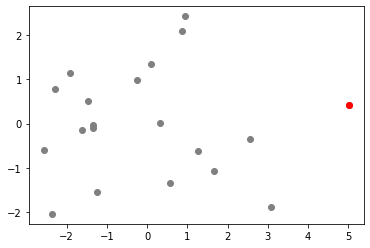



The Outstanding players for NBA All Star in the year 1967 are : 
Mel Daniels
John Havlicek


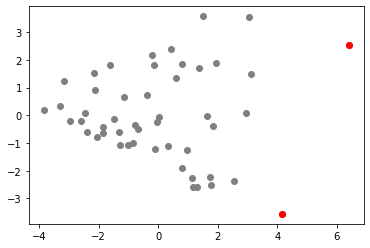



The Outstanding players for NBA All Star in the year 1968 are : 
Darel Carrier
Donnie Freeman
Larry Jones
Louie Dampier
John Beasley


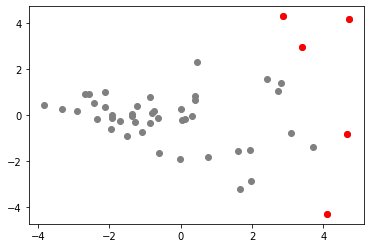



The Outstanding players for NBA All Star in the year 1969 are : 
Larry Jones


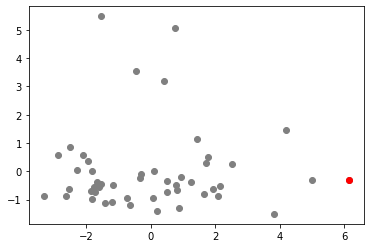



The Outstanding players for NBA All Star in the year 1970 are : 
Mel Daniels


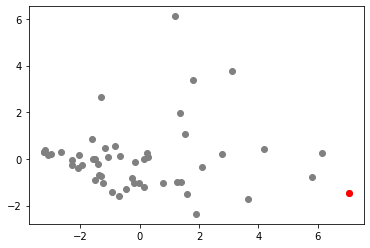



The Outstanding players for NBA All Star in the year 1971 are : 
Dan Issel
Jim McDaniels
Mel Daniels
Charlie Scott


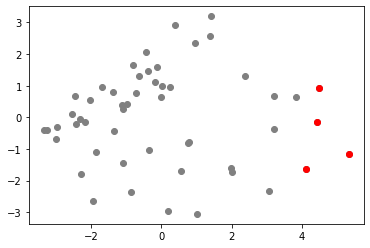



The Outstanding players for NBA All Star in the year 1972 are : 
Warren Jabali
Mel Daniels


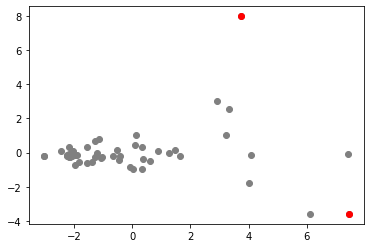



The Outstanding players for NBA All Star in the year 1973 are : 
Swen Nater


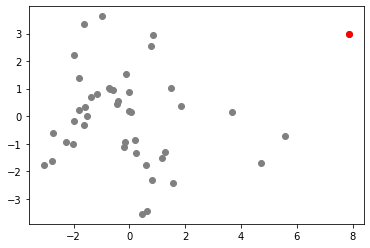



The Outstanding players for NBA All Star in the year 1974 are : 
Freddie Lewis
George Gervin
Julius Erving
George McGinnis


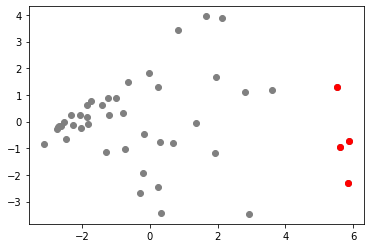



The Outstanding players for NBA All Star in the year 1975 are : 
Claude Terry
David Thompson


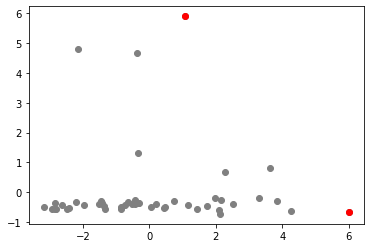



The Outstanding players for NBA All Star in the year 1976 are : 
Bob McAdoo
Julius Erving


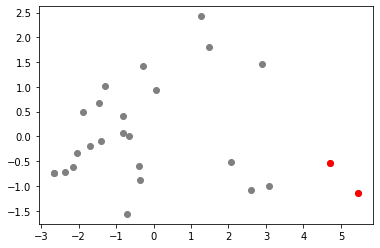



The Outstanding players for NBA All Star in the year 1977 are : 
Doug Collins
Pete Maravich
Julius Erving
Randy Smith


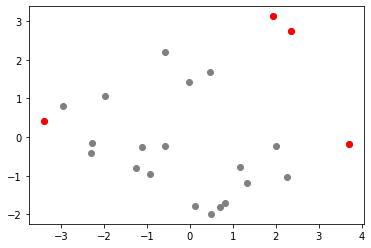



The Outstanding players for NBA All Star in the year 1978 are : 
Julius Erving
George Gervin


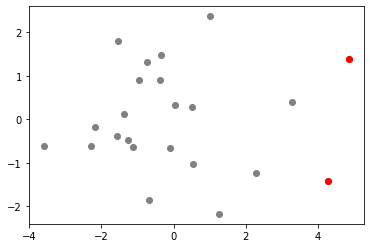



The Outstanding players for NBA All Star in the year 1979 are : 
George Gervin


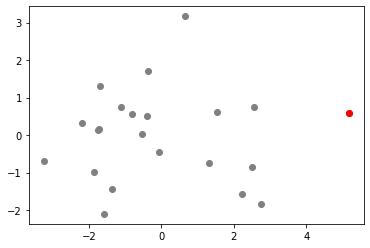



The Outstanding players for NBA All Star in the year 1980 are : 
Dennis Johnson
Dan Roundfield


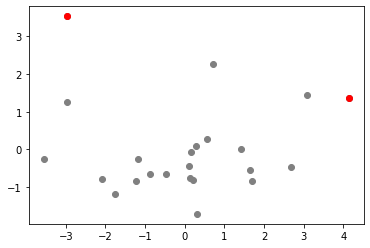



The Outstanding players for NBA All Star in the year 1981 are : 
Dennis Johnson
Dan Roundfield


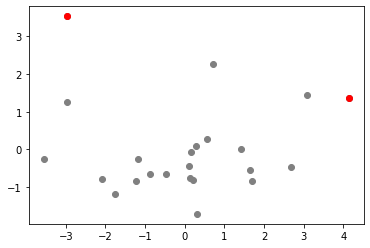



The Outstanding players for NBA All Star in the year 1982 are : 
Julius Erving
Magic Johnson
Sidney Moncrief


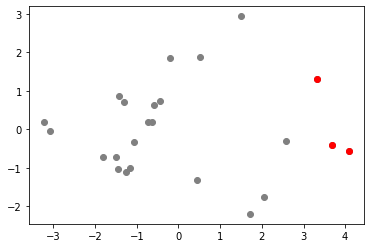



The Outstanding players for NBA All Star in the year 1983 are : 
Julius Erving


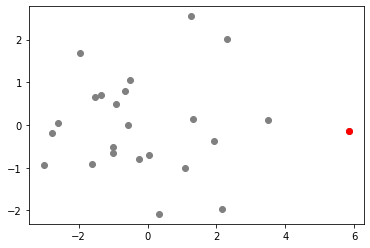



The Outstanding players for NBA All Star in the year 1984 are : 
Magic Johnson
Ralph Sampson


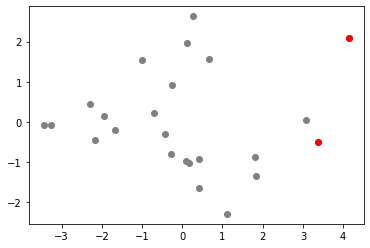



The Outstanding players for NBA All Star in the year 1985 are : 
Isiah Thomas


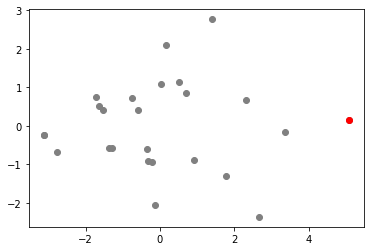



The Outstanding players for NBA All Star in the year 1986 are : 
Moses Malone
Rolando Blackman
Tom Chambers


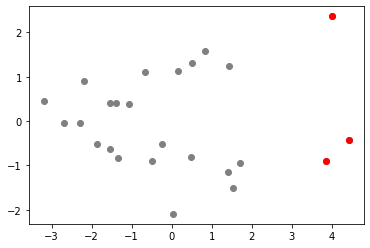



The Outstanding players for NBA All Star in the year 1987 are : 
Magic Johnson
Michael Jordan


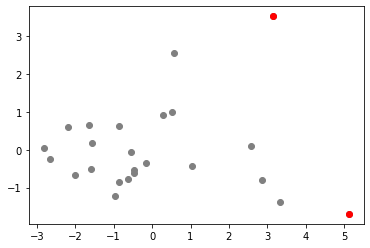



The Outstanding players for NBA All Star in the year 1988 are : 
Michael Jordan
Karl Malone


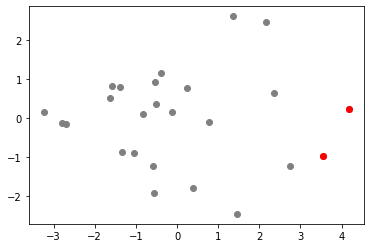



The Outstanding players for NBA All Star in the year 1989 are : 
Hakeem Olajuwon
Tom Chambers


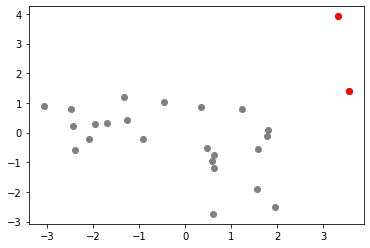



The Outstanding players for NBA All Star in the year 1990 are : 
Charles Barkley
Michael Jordan


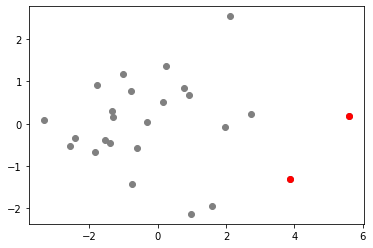



The Outstanding players for NBA All Star in the year 1991 are : 
Magic Johnson
David Robinson


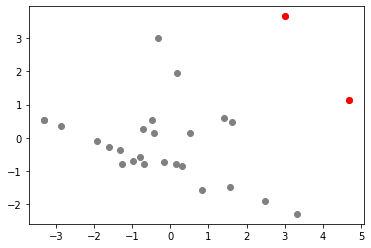



The Outstanding players for NBA All Star in the year 1992 are : 
Michael Jordan
Karl Malone


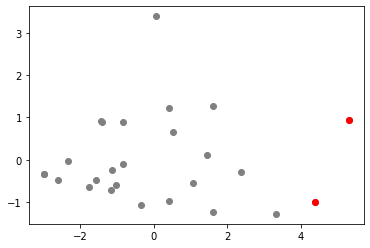



The Outstanding players for NBA All Star in the year 1993 are : 
Scottie Pippen


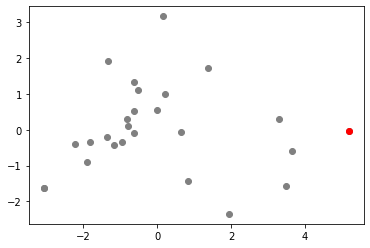



The Outstanding players for NBA All Star in the year 1994 are : 
Shaquille O'Neal


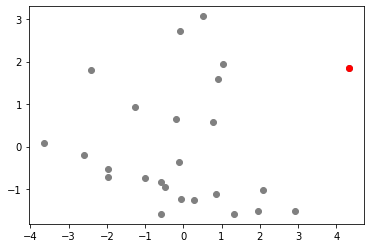



The Outstanding players for NBA All Star in the year 1995 are : 
Shaquille O'Neal


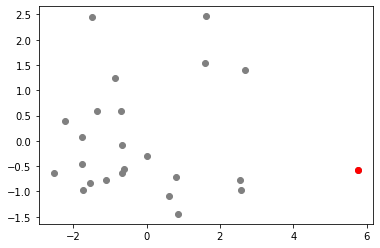



The Outstanding players for NBA All Star in the year 1996 are : 
Michael Jordan
Glen Rice


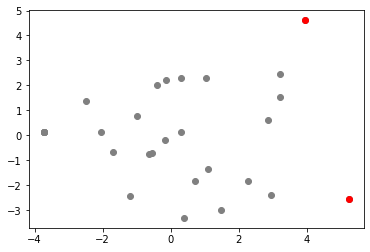



The Outstanding players for NBA All Star in the year 1997 are : 
David Robinson


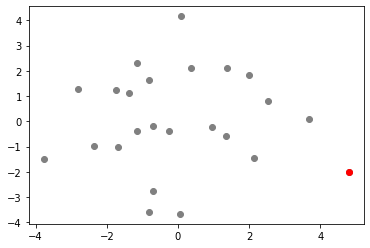



The Outstanding players for NBA All Star in the year 1999 are : 
Jason Kidd
Allen Iverson
Shaquille O'Neal
Tim Duncan


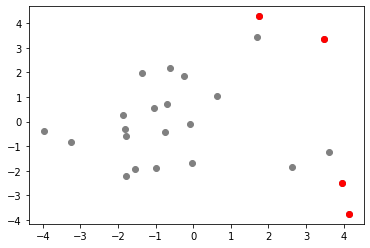



The Outstanding players for NBA All Star in the year 2000 are : 
Dikembe Mutombo


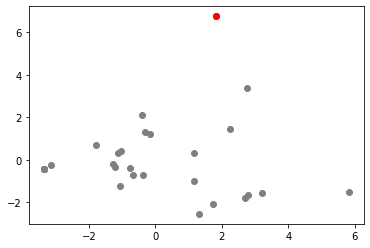



The Outstanding players for NBA All Star in the year 2001 are : 
Kobe Bryant


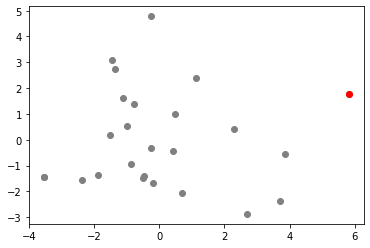



The Outstanding players for NBA All Star in the year 2002 are : 
Kevin Garnett
Allen Iverson


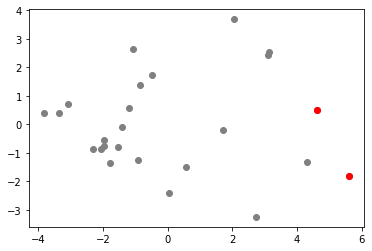



The Outstanding players for NBA All Star in the year 2003 are : 
Shaquille O'Neal


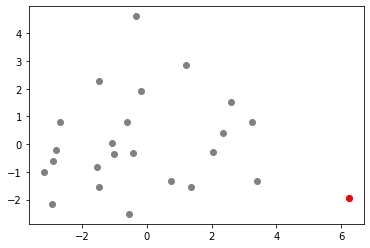

In [5]:
# Running code
# Run either KNN or KMeans block to define methods before running this block

readPlayerFiles("/content/drive/MyDrive/Colab Notebooks/Data/player_regular_season_career.txt", 8, 23, "NBA Regular Seasons in general")
print("===================================================================")

readPlayerFiles("/content/drive/MyDrive/Colab Notebooks/Data/player_playoffs_career.txt", 8, 21, "NBA Playoffs in General")
print("===================================================================")

readPlayerFiles("/content/drive/MyDrive/Colab Notebooks/Data/player_regular_season.txt", 6, 23, "NBA Regular Seasons")
print("===================================================================")

readPlayerFiles("/content/drive/MyDrive/Colab Notebooks/Data/player_playoffs.txt", 8, 23, "NBA Playoffs")
print("===================================================================")

readPlayerFiles("/content/drive/MyDrive/Colab Notebooks/Data/player_allstar.txt", 8, 23, "NBA All Star")

# Game Outcome Prediction

In [12]:
# Defined Methods
def get_win_rate(teamSeasonRow):
		return teamSeasonRow["won"] / (teamSeasonRow["won"] + teamSeasonRow["lost"])
  
def get_o_3pm_value(teamSeasonRow):
		teamSeasonWinRate = get_win_rate(teamSeasonRow)
		if teamSeasonRow["year"] < 1979:
			o_3pmMultiplier = 1 + ((teamSeasonWinRate - averageWinRate) / averageWinRate)
			return int(round(o_3pmAverage * o_3pmMultiplier, ndigits=0))
		else:
			return teamSeasonRow["o_3pm"]

def get_d_3pm_value(teamSeasonRow):
		teamSeasonWinRate = get_win_rate(teamSeasonRow)
		if teamSeasonRow["year"] < 1979:
			d_3pmMultiplier = 1 + ((teamSeasonWinRate - averageWinRate) / averageWinRate)
			return int(round(d_3pmAverage * d_3pmMultiplier, ndigits=0))
		else:
			return teamSeasonRow["d_3pm"]

def get_o_3pa_value(teamSeasonRow):
		if teamSeasonRow["year"] < 1999:
			return int(round(teamSeasonRow["o_3pm"] * o_3paMultiplier, ndigits=0))
		else:
			return teamSeasonRow["o_3pa"]

def get_d_3pa_value(teamSeasonRow):
		if teamSeasonRow["year"] < 1999:
			return int(round(teamSeasonRow["d_3pm"] * d_3paMultiplier, ndigits=0))
		else:
			return teamSeasonRow["d_3pa"]

In [13]:
# Load Data
teamSeasonDF = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/team_season.txt", header=0)
teamSeasonDF.drop(teamSeasonDF[teamSeasonDF.year < 1976].index, inplace=True)
teamSeasonDF.reset_index(inplace=True, drop=True) 

# Model Training
labelsDF = pd.DataFrame(columns=["win_rate"])
labelsDF["win_rate"] = teamSeasonDF.apply(get_win_rate, axis=1)

averageWinRate = teamSeasonDF["won"].sum() / (teamSeasonDF["won"].sum() + teamSeasonDF["lost"].sum())

teamSeason1979DF = teamSeasonDF[teamSeasonDF.year >= 1979]

o_3pmDF = teamSeason1979DF["o_3pm"]
o_3pmAverage = o_3pmDF.sum() / len(teamSeason1979DF.index)

d_3pmDF = teamSeason1979DF["d_3pm"]
d_3pmAverage = d_3pmDF.sum() / len(teamSeason1979DF.index)

teamSeasonDF["o_3pm"] = teamSeasonDF.apply(get_o_3pm_value, axis=1)
teamSeasonDF["d_3pm"] = teamSeasonDF.apply(get_d_3pm_value, axis=1)

teamSeason1999DF = teamSeasonDF[teamSeasonDF.year >= 1999]

o_3pmDF = teamSeason1999DF["o_3pm"]
o_3paDF = teamSeason1999DF["o_3pa"]
o_3paMultiplier = o_3paDF.sum() / o_3pmDF.sum()

d_3pmDF = teamSeason1999DF["d_3pm"]
d_3paDF = teamSeason1999DF["d_3pa"]
d_3paMultiplier = d_3paDF.sum() / d_3pmDF.sum()

teamSeasonDF["o_3pa"] = teamSeasonDF.apply(get_o_3pa_value, axis=1)
teamSeasonDF["d_3pa"] = teamSeasonDF.apply(get_d_3pa_value, axis=1)

# Create dataframe with only required features
featureMatrixDF = teamSeasonDF.drop(["team", "year", "leag", "won", "lost"], axis=1)

featuresTrain, featuresTest, labelsTrain, labelsTest = train_test_split(featureMatrixDF, labelsDF, train_size=0.80, random_state=1)

scaler = preprocessing.StandardScaler()
scaler.fit(featuresTrain)

featuresTrainNormalised = pd.DataFrame(scaler.transform(featuresTrain), columns=featuresTrain.columns)
featuresTestNormalised = pd.DataFrame(scaler.transform(featuresTest), columns=featuresTest.columns)

mlpRegressor = MLPRegressor(hidden_layer_sizes=(100, 100, 100), solver="lbfgs", activation="tanh", random_state=1, max_iter=10000)
svRegressor = SVR()

for algorithm in [mlpRegressor, svRegressor]:
		print("Algorithm:", algorithm.__class__.__name__)
		print()
		algorithm.fit(featuresTrainNormalised, np.ravel(labelsTrain))
		labelPredictions = algorithm.predict(featuresTestNormalised)
		print("\tPrediction Metrics:")
		print("\t\tMax Error: ", round(max_error(labelsTest, labelPredictions), 3))
		print("\t\tExplained Variance Score: ", round(explained_variance_score(labelsTest, labelPredictions), 3))
		print("\t\tMean Absolute Error: ", round(mean_absolute_error(labelsTest, labelPredictions), 3))
		print("\t\tMean Squared Error: ", round(mean_squared_error(labelsTest, labelPredictions), 3))
		print("\t\tMedian Absolute Error: ", round(median_absolute_error(labelsTest, labelPredictions), 3))
		print("\t\tR2 Score: ", round(r2_score(labelsTest, labelPredictions), 3))
		print()

Algorithm: MLPRegressor

	Prediction Metrics:
		Max Error:  0.168
		Explained Variance Score:  0.867
		Mean Absolute Error:  0.045
		Mean Squared Error:  0.003
		Median Absolute Error:  0.039
		R2 Score:  0.867

Algorithm: SVR

	Prediction Metrics:
		Max Error:  0.21
		Explained Variance Score:  0.823
		Mean Absolute Error:  0.053
		Mean Squared Error:  0.004
		Median Absolute Error:  0.046
		R2 Score:  0.822



In [14]:
# Load teams.txt
teamsFile = "/content/drive/MyDrive/Colab Notebooks/Data/teams.txt"
teamsDF = pd.read_csv(teamsFile)
print(teamsDF.head())

  team   location            name leag
0  ANA    Anaheim          Amigos    A
1  AND   Anderson  Duffey Packers    N
2  ATL    Atlanta           Hawks    N
3  BA1  Baltimore         Bullets    N
4  BAL  Baltimore         Bullets    N


In [15]:
# Choose 2 teams for comparison
compareDF = teamSeasonDF.sample(n=2)
print(compareDF)

    team  year leag  o_fgm  o_fga  o_ftm  o_fta  o_oreb  o_dreb  o_reb  ...  \
312  MIN  1989    N   3067   6876   1596   2137    1196    2053   3249  ...   
667  DEN  2002    N   2689   6544   1294   1850    1112    2363   3475  ...   

     d_pf  d_stl  d_to  d_blk  d_3pm  d_3pa  d_pts       pace  won  lost  
312  1748    578  1366    489    129    366   8150  94.217224   22    60  
667  1788    742  1339    532    420   1134   7580  92.254524   17    65  

[2 rows x 36 columns]


In [16]:
# Display teams for comparison
team1Label = compareDF.iloc[0, 0]
team1year = compareDF.iloc[0, 1]

team2Label = compareDF.iloc[1, 0]
team2year = compareDF.iloc[1, 1]

team1row = teamsDF.loc[teamsDF['team']==team1Label]
team1 = "Team 1 : " + str(team1row.iloc[0, 1]) + " " + str(team1row.iloc[0, 2])
print(team1)
print("Year : ", team1year)
print()

team2row = teamsDF.loc[teamsDF['team']==team2Label]
team2 = "Team 2 : " + str(team2row.iloc[0, 1]) + " " + str(team2row.iloc[0, 2])
print(team2)
print("Year : ", team2year)

compareDF = compareDF.drop(['won', 'lost', 'year', 'leag', 'team'], axis=1)

Team 1 : Minnesota Timberwolves
Year :  1989

Team 2 : Denver Rockets
Year :  2002


In [17]:
# Prediction
print("Model - MLP Regression")
print()

winProbability = mlpRegressor.predict(compareDF)
winProbT1 = winProbability[0]
winProbT2 = winProbability[1]

print("Win Probability of Team 1: ", winProbT1)
print("Win Probability of Team 2: ", winProbT2)
print()

# Normalization
normWinProbT1 = winProbT1 / (winProbT1 + winProbT2)
normWinProbT2 = winProbT2 / (winProbT1 + winProbT2)

print("The probability of Team 1 beating Team 2 is: ", normWinProbT1)
print("The probability of Team 2 beating Team 1 is: ", normWinProbT2)

if (normWinProbT1 > normWinProbT2) :
  winner = team1
else :
  winner = team2

print()
print("The winner is ", winner)

Model - MLP Regression

Win Probability of Team 1:  0.673953241661807
Win Probability of Team 2:  0.6111701824183947

The probability of Team 1 beating Team 2 is:  0.5244268597346391
The probability of Team 2 beating Team 1 is:  0.47557314026536096

The winner is  Team 1 : Minnesota Timberwolves
